In [17]:
import numpy as np
from scipy import fft
from matplotlib import pyplot as plt
import scipy.io

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os
os.chdir(f'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing'

In [31]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/MathematicalModelMethodImageProcessing/Assignments_24_25/data'

Generating 1-D DCT basis
------------------------


In [19]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)
c_0 = np.sqrt(1/M)
c_k = np.sqrt(2/M)
pi = np.pi
for k in range(M):
  # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
  for n in range(N):
    if k == 0:
      DCT[n,k] = c_0*np.cos(k*pi*((2*n +1)/(2*M)))
    else:
      DCT[n,k] = c_k*np.cos(k*pi*((2*n +1)/(2*M)))

  DCT[:,k] = DCT[:,k]/np.linalg.norm(DCT[:,k])

Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

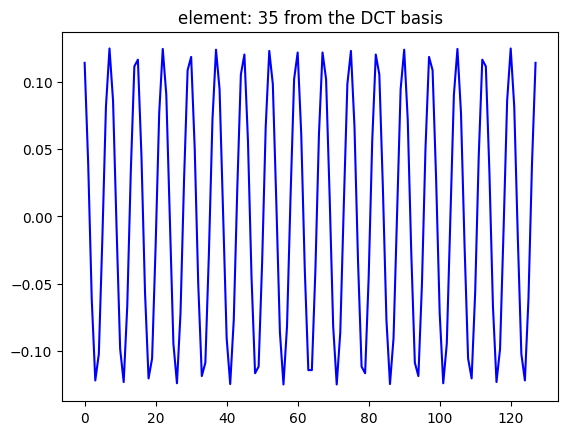

In [20]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [21]:
dot_product = np.dot(DCT,DCT.T)
identity_matrix = np.identity(len(DCT))
threshold = 1e-10
is_DCT_orth = np.allclose(dot_product, identity_matrix , atol=threshold)
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

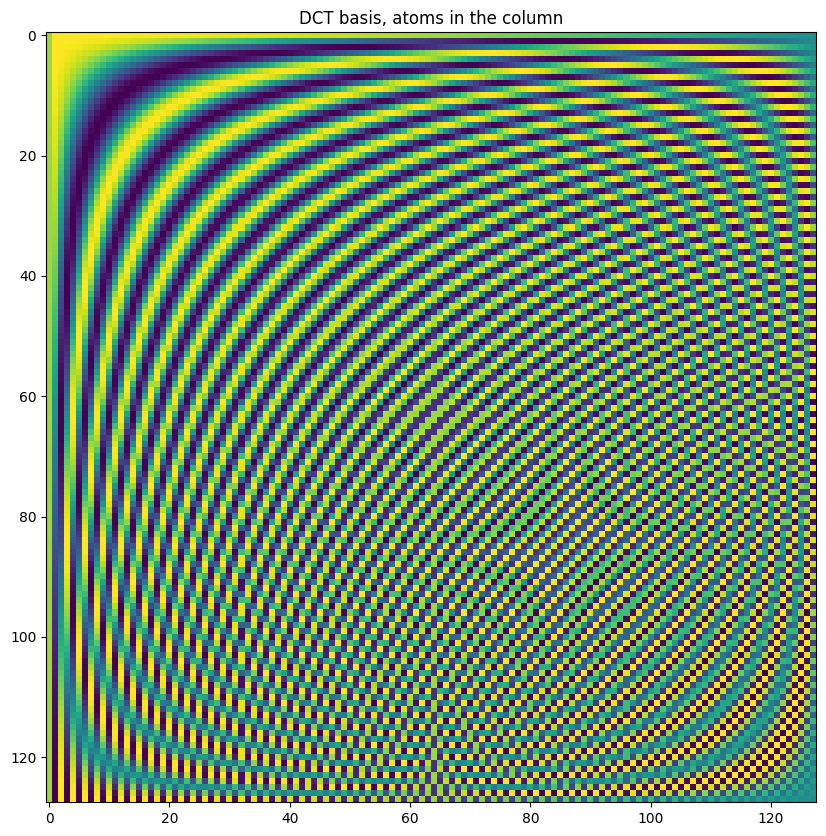

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')





Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [44]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = fft.idct(a, norm='ortho')

Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

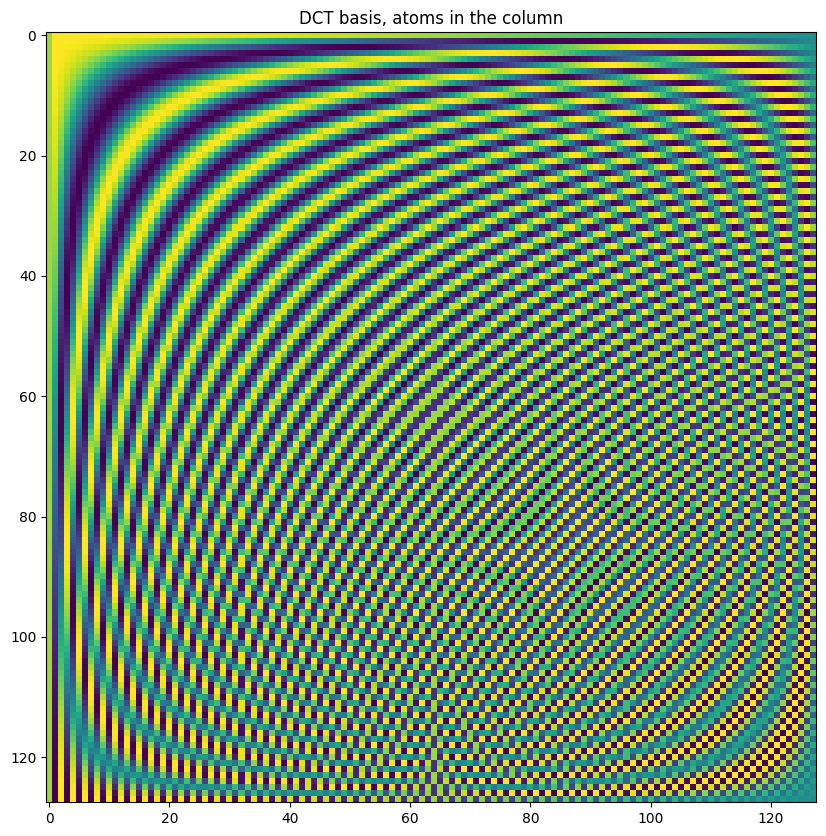

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [45]:
is_DCT_equal_D = np.allclose(DCT,D,atol=threshold)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [47]:
temp = scipy.io.loadmat(f'{rootfolder}/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [49]:
for i in range(nBeats):
    X[:, i] = np.dot(D.T,S[:,i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

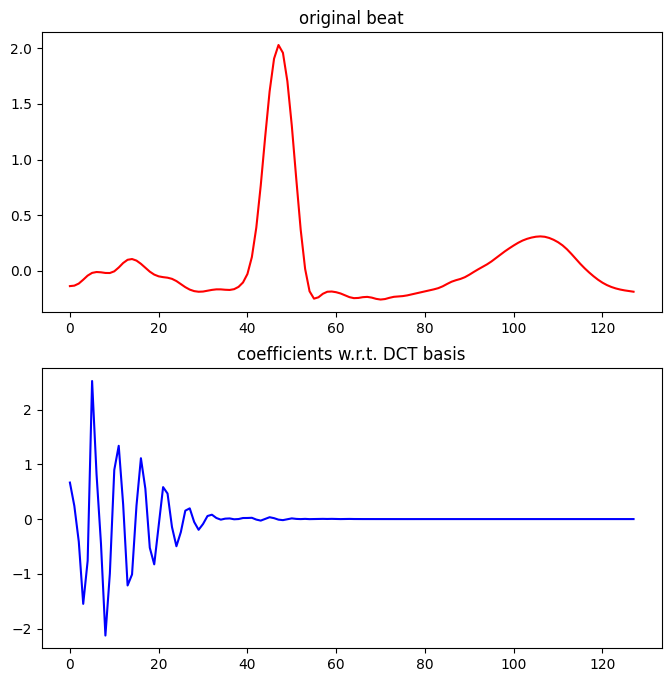

In [50]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [35]:
S_hat_D = np.dot(D, X)

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [36]:
is_reconstruction_perfect = np.allclose(S_hat_D, S, atol=threshold)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [37]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [38]:
for i in range(nBeats):
    X[:, i] = np.dot(D.T,S[:,i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

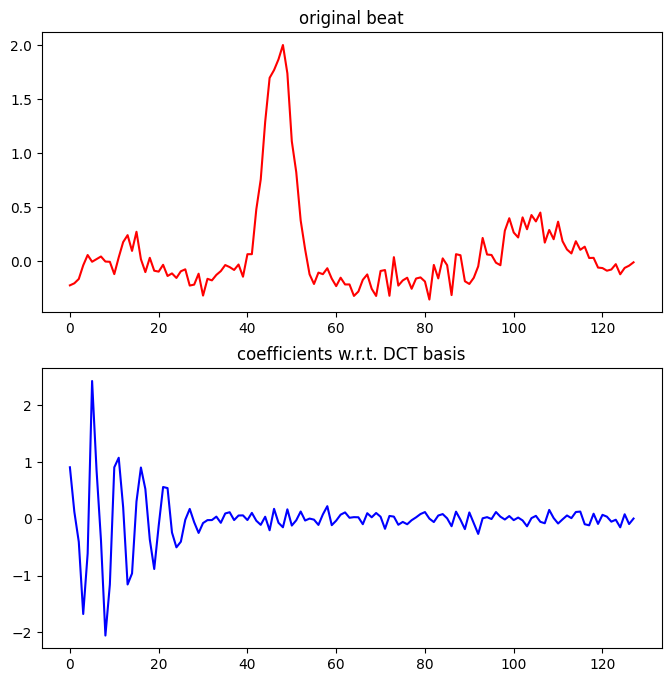

In [39]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [40]:
def hard_thresholding_function(coeff_x,L):
  # get the indeces of the L largest coefficients
  top_L_indices = np.argsort(np.abs(coeff_x))[-L:]
  # set all coefficients to zero
  coeff_x[~np.isin(np.arange(len(coeff_x)), top_L_indices)] = 0
  return coeff_x

In [41]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 21 # sparsity level (try different values)

for i in range(nBeats):
    origSignal =  S0[:,i]
    noisySignal = S[:,i]

    # transform each signal separately (analysis)
    x = np.dot(D.T,noisySignal)

    # keep only the L largest coefficients (absolute value)
    X_HT[:, i] = hard_thresholding_function(x,L)

    # invert the transformation
    s_hat = np.dot(D,X_HT[:,i])

    S_hat[:, i] = s_hat

Display a signal

Text(0.5, 1.0, 'DCT coefficients')

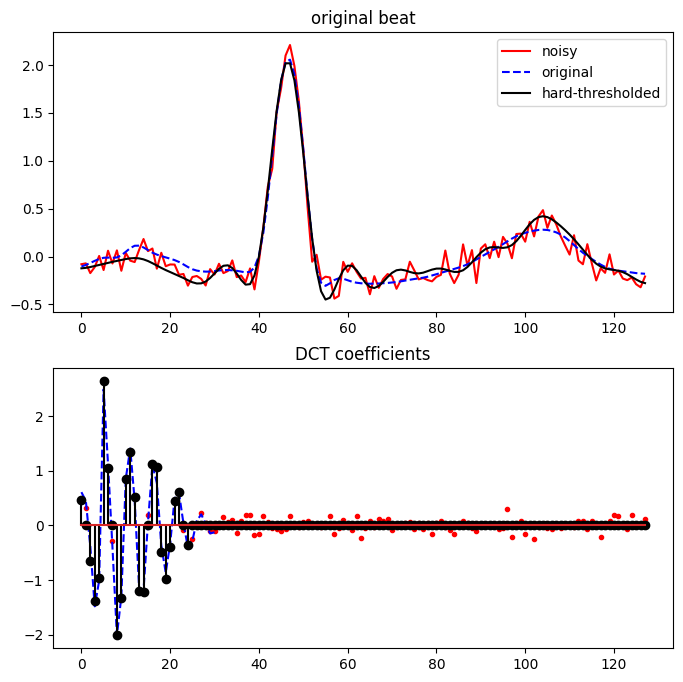

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

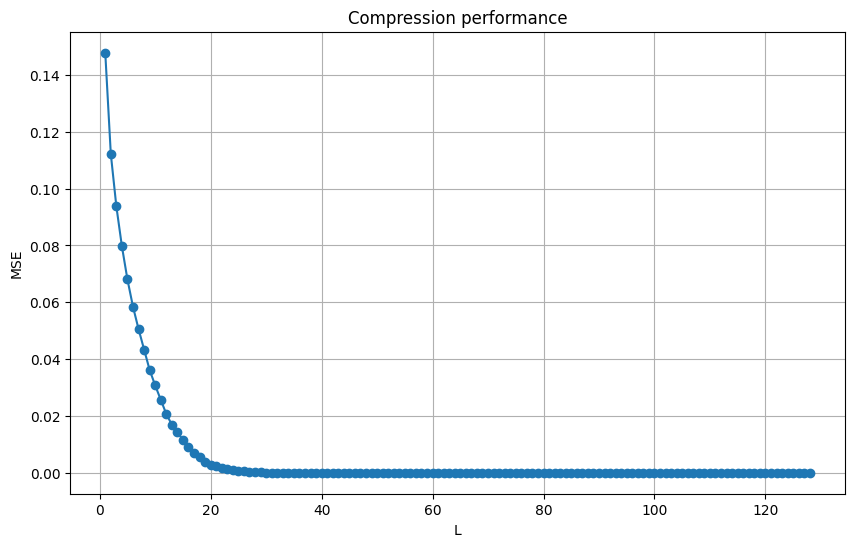

In [51]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
     # transform each signal separately (analysis)
    x = np.dot(D.T,origSignal)

    # keep only the L largest coefficients (absolute value)
    x_HT = hard_thresholding_function(x,L)

    # invert the transformation
    s_hat = np.dot(D, x_HT)

    mse =  np.mean(np.square(S0[:,0] - s_hat))

    MSE_values[L-1] = mse

plt.figure(figsize=(10,6))
plt.plot(L_values, MSE_values, '-o')
plt.xlabel('L')
plt.ylabel('MSE')
plt.title('Compression performance')
plt.grid()